# Coin Classification Kaggle Mini-Project
**GitHub Repository**: https://github.com/ilichenko/DTSA-5511

**Kaggle Competition**: https://www.kaggle.com/competitions/dl4cv-coin-classification/data

Useful guide on how to install TensorFlow in Jupyter Notebook: https://how.dev/answers/how-to-install-tensorflow-in-jupyter-notebook

## 1. Introduction
### 1.1. Problem Statement
This study focuses on the development of deep learning models for the task of multi-class image classification. The goal is to correctly identify coins from various countries and currencies based on photographic images. Each image belongs to one of 315 unique classes, which are defined by a combination of denomination, currency, and country (e.g., "20 Hellers, Czech Koruna, Czech Republic").

### 1.2. Study Objective
The objective of this study is to explore, train, and evaluate convolutional neural network (CNN) models capable of accurately classifying images of coins. The models are expected to learn visual patterns related to coin text, shape, and imagery, and ultimately achieve high classification performance across classes.

### 1.3. Dataset Overview
The dataset used in this competition consists of colored coin images sourced from coin-collector websites and the WanderDust Coin Images dataset. The data has been split into training and test sets:
- **Training Set**: ~10,400 labeled images (approximately 85% of the full dataset).
- **Test Set**: ~1,288 unlabeled images (approximately 15%). 
- **Training Labels**: Provided in `train.csv`, indicating the image ids of the training set together with classes as a combination of denomination, currency, and country.
- **Test Labels**: Provided in `test.csv`, indicating the image ids of the test set.

## 2. Exploratory Data Analysis (EDA) and Data Preprocessing

The following code installs the required libraries and imports the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path    
from PIL import Image
from tqdm import tqdm

In [2]:
TRAIN_DIR = Path("train")
TEST_DIR = Path("test")
TRAIN_LABELS = Path("train.csv")
TEST_LABELS = Path("test.csv")

train_df = pd.read_csv(TRAIN_LABELS)
test_df = pd.read_csv(TEST_LABELS)
train_df.head()

,Id,Class
0,1,"1 Cent,Australian dollar,australia"
1,2,"1 Cent,Australian dollar,australia"
2,3,"1 Cent,Australian dollar,australia"
3,4,"1 Cent,Australian dollar,australia"
4,5,"1 Cent,Australian dollar,australia"


Out of the `Class` column in our dataframe, we extract three features: `denomination`, `currency`, and `country`. This will facilitate more structured data cleaning and downstream analysis:

In [3]:
train_df[['denomination', 'currency', 'country']] = train_df['Class'].str.split(',', expand=True)

train_df['denomination'] = train_df['denomination'].str.strip()
train_df['currency'] = train_df['currency'].str.strip()
train_df['country'] = train_df['country'].str.strip()
train_df

,Id,Class,denomination,currency,country
0,1,"1 Cent,Australian dollar,australia",1 Cent,Australian dollar,australia
1,2,"1 Cent,Australian dollar,australia",1 Cent,Australian dollar,australia
2,3,"1 Cent,Australian dollar,australia",1 Cent,Australian dollar,australia
3,4,"1 Cent,Australian dollar,australia",1 Cent,Australian dollar,australia
4,5,"1 Cent,Australian dollar,australia",1 Cent,Australian dollar,australia
...,...,...,...,...,...
10363,11648,"50 Cents,Euro,spain",50 Cents,Euro,spain
10364,11649,"50 Cents,Euro,spain",50 Cents,Euro,spain
10365,11650,"50 Cents,Euro,spain",50 Cents,Euro,spain
10366,11651,"50 Cents,Euro,spain",50 Cents,Euro,spain


Next, we check the unique values of each of the three extracted columns to understand their variability and potential inconsistencies:

In [32]:
sorted(train_df['denomination'].unique().tolist())[:15]

['1 2 Dollar',
 '1 2 Franc',
 '1 2 New Sheqel',
 '1 4 Dollar',
 '1 Baht',
 '1 Cent',
 '1 Centavo',
 '1 Dime',
 '1 Dollar',
 '1 Euro',
 '1 Forint',
 '1 Franc',
 '1 Grosz',
 '1 Jiao',
 '1 Kopek']

In [33]:
sorted(train_df['currency'].unique().tolist())[:15]

['Armenian Dram',
 'Australian Dollar',
 'Brazilian Real',
 'British Pound',
 'Canadian Dollar',
 'Chilean Peso',
 'Chinese Yuan Renminbi',
 'Czech Koruna',
 'Danish Krone',
 'Estonian Kroon',
 'Euro',
 'Hong Kong Dollar',
 'Hungarian Forint',
 'Indian Rupee',
 'Indonesian Rupiah']

In [34]:
sorted(train_df['country'].unique().tolist())[:15]

['Armenia',
 'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Canada',
 'Chile',
 'China',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany']

We notice some unexpected entries in `denomination` such as "*1 2*". We investigate what these values could represent and whether they are valid entries or data errors:

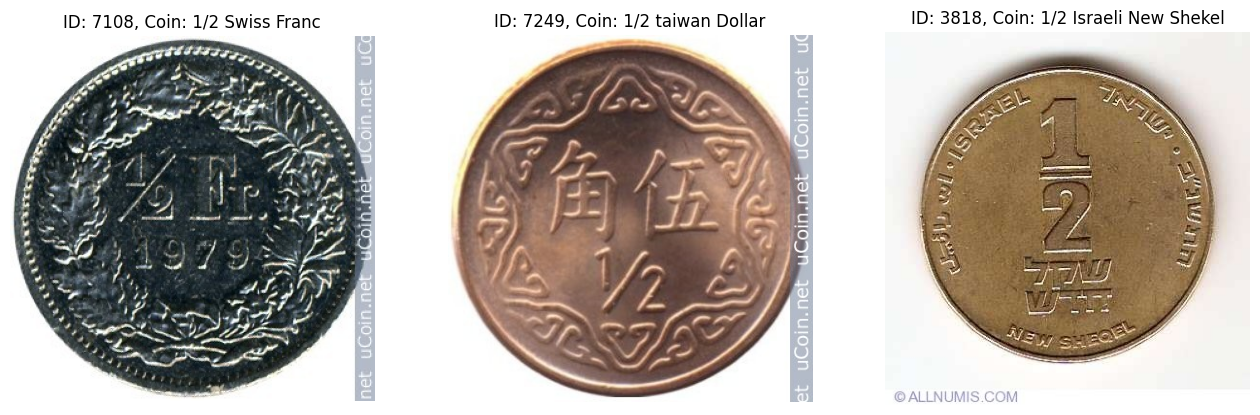

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 12))

for i, image_id in enumerate([7108, 7249, 3818]):
    image_path = os.path.join(TRAIN_DIR, f'{image_id}.jpg')
    currency_value = train_df[train_df['Id'] == image_id]["currency"].values[0]
    
    img = Image.open(image_path)

    axes[i].imshow(img)
    axes[i].set_title(f'ID: {image_id}, Coin: 1/2 {currency_value}')
    axes[i].axis('off')

plt.show()

Upon inspection, we find that "*1 2*" represents fractional denominations such as 1/2 dollar or 1/2 franc. These are legitimate values, so we retain them as they are.

We also detect inconsistencies in capitalization in the `country` column — for instance, "*Estonia*" vs. "*estonia*" and "*Pakistan*" vs. "*pakistan*". These should be standardized to avoid introducing artificial distinctions:

In [8]:
for col in ['denomination', 'currency', 'country']:
    train_df[col] = train_df[col].str.replace('_', ' ').str.title()
train_df

,Id,Class,denomination,currency,country
0,1,"1 Cent,Australian dollar,australia",1 Cent,Australian Dollar,Australia
1,2,"1 Cent,Australian dollar,australia",1 Cent,Australian Dollar,Australia
2,3,"1 Cent,Australian dollar,australia",1 Cent,Australian Dollar,Australia
3,4,"1 Cent,Australian dollar,australia",1 Cent,Australian Dollar,Australia
4,5,"1 Cent,Australian dollar,australia",1 Cent,Australian Dollar,Australia
...,...,...,...,...,...
10363,11648,"50 Cents,Euro,spain",50 Cents,Euro,Spain
10364,11649,"50 Cents,Euro,spain",50 Cents,Euro,Spain
10365,11650,"50 Cents,Euro,spain",50 Cents,Euro,Spain
10366,11651,"50 Cents,Euro,spain",50 Cents,Euro,Spain


Now we explore the distribution of the labels in the dataset to assess class representation:

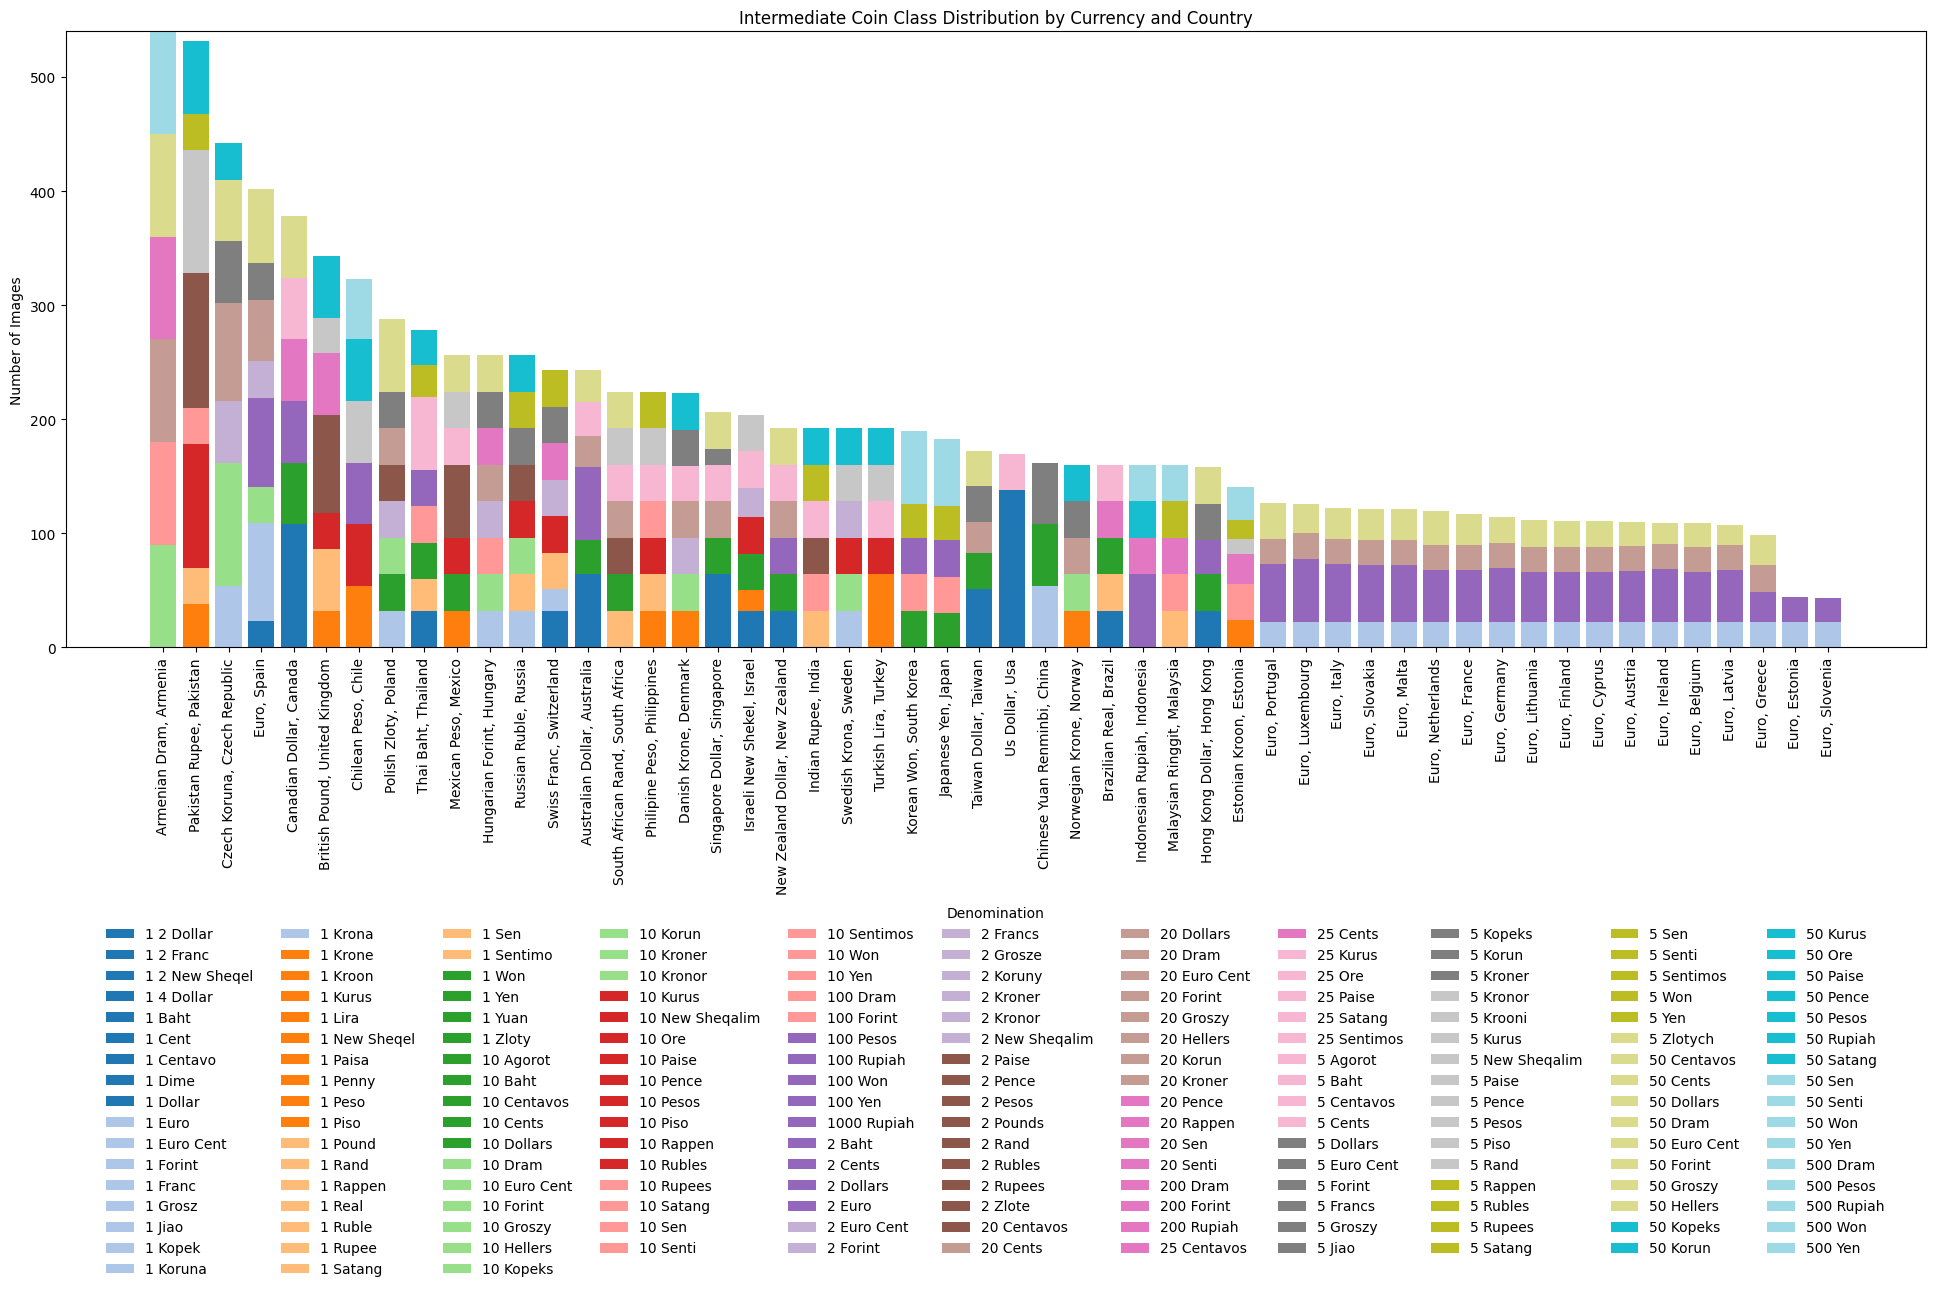

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

_df = train_df.copy()
_df['currency_n_country'] = _df['currency'].str.strip() + ', ' + _df['country'].str.strip()
grouped = _df.groupby(['currency_n_country', 'denomination']).size().unstack(fill_value=0)
grouped = grouped.loc[grouped.sum(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(24, 8))
x = np.arange(len(grouped))
bottom = np.zeros(len(grouped))

for i, denom in enumerate(grouped.columns):
    values = grouped[denom].values
    colors = plt.cm.tab20(np.linspace(0, 1, len(grouped.columns)))
    ax.bar(x, values, bottom=bottom, width=0.8, color=colors[i])
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(grouped.index, rotation=90)
ax.set_title("Intermediate Coin Class Distribution by Currency and Country")
ax.set_ylabel("Number of Images")
ax.legend(grouped.columns, title='Denomination', loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=11, frameon=False)
plt.show()

From the label distribution, we observe issues like Spain having both "*1 Cent*" and "*1 Euro Cent*" for the Euro currency. We also see mixed use of "*Cents*" and "*Euro Cent*". For consistency, we unify all such cases under "*Cents*":

In [11]:
euro_cent_map = {
    '1 Euro Cent': '1 Cent',
    '2 Euro Cent': '2 Cents',
    '5 Euro Cent': '5 Cents',
    '10 Euro Cent': '10 Cents',
    '20 Euro Cent': '20 Cents',
    '50 Euro Cent': '50 Cents'}
train_df['denomination'] = train_df['denomination'].replace(euro_cent_map)

Plotting the final distribution:

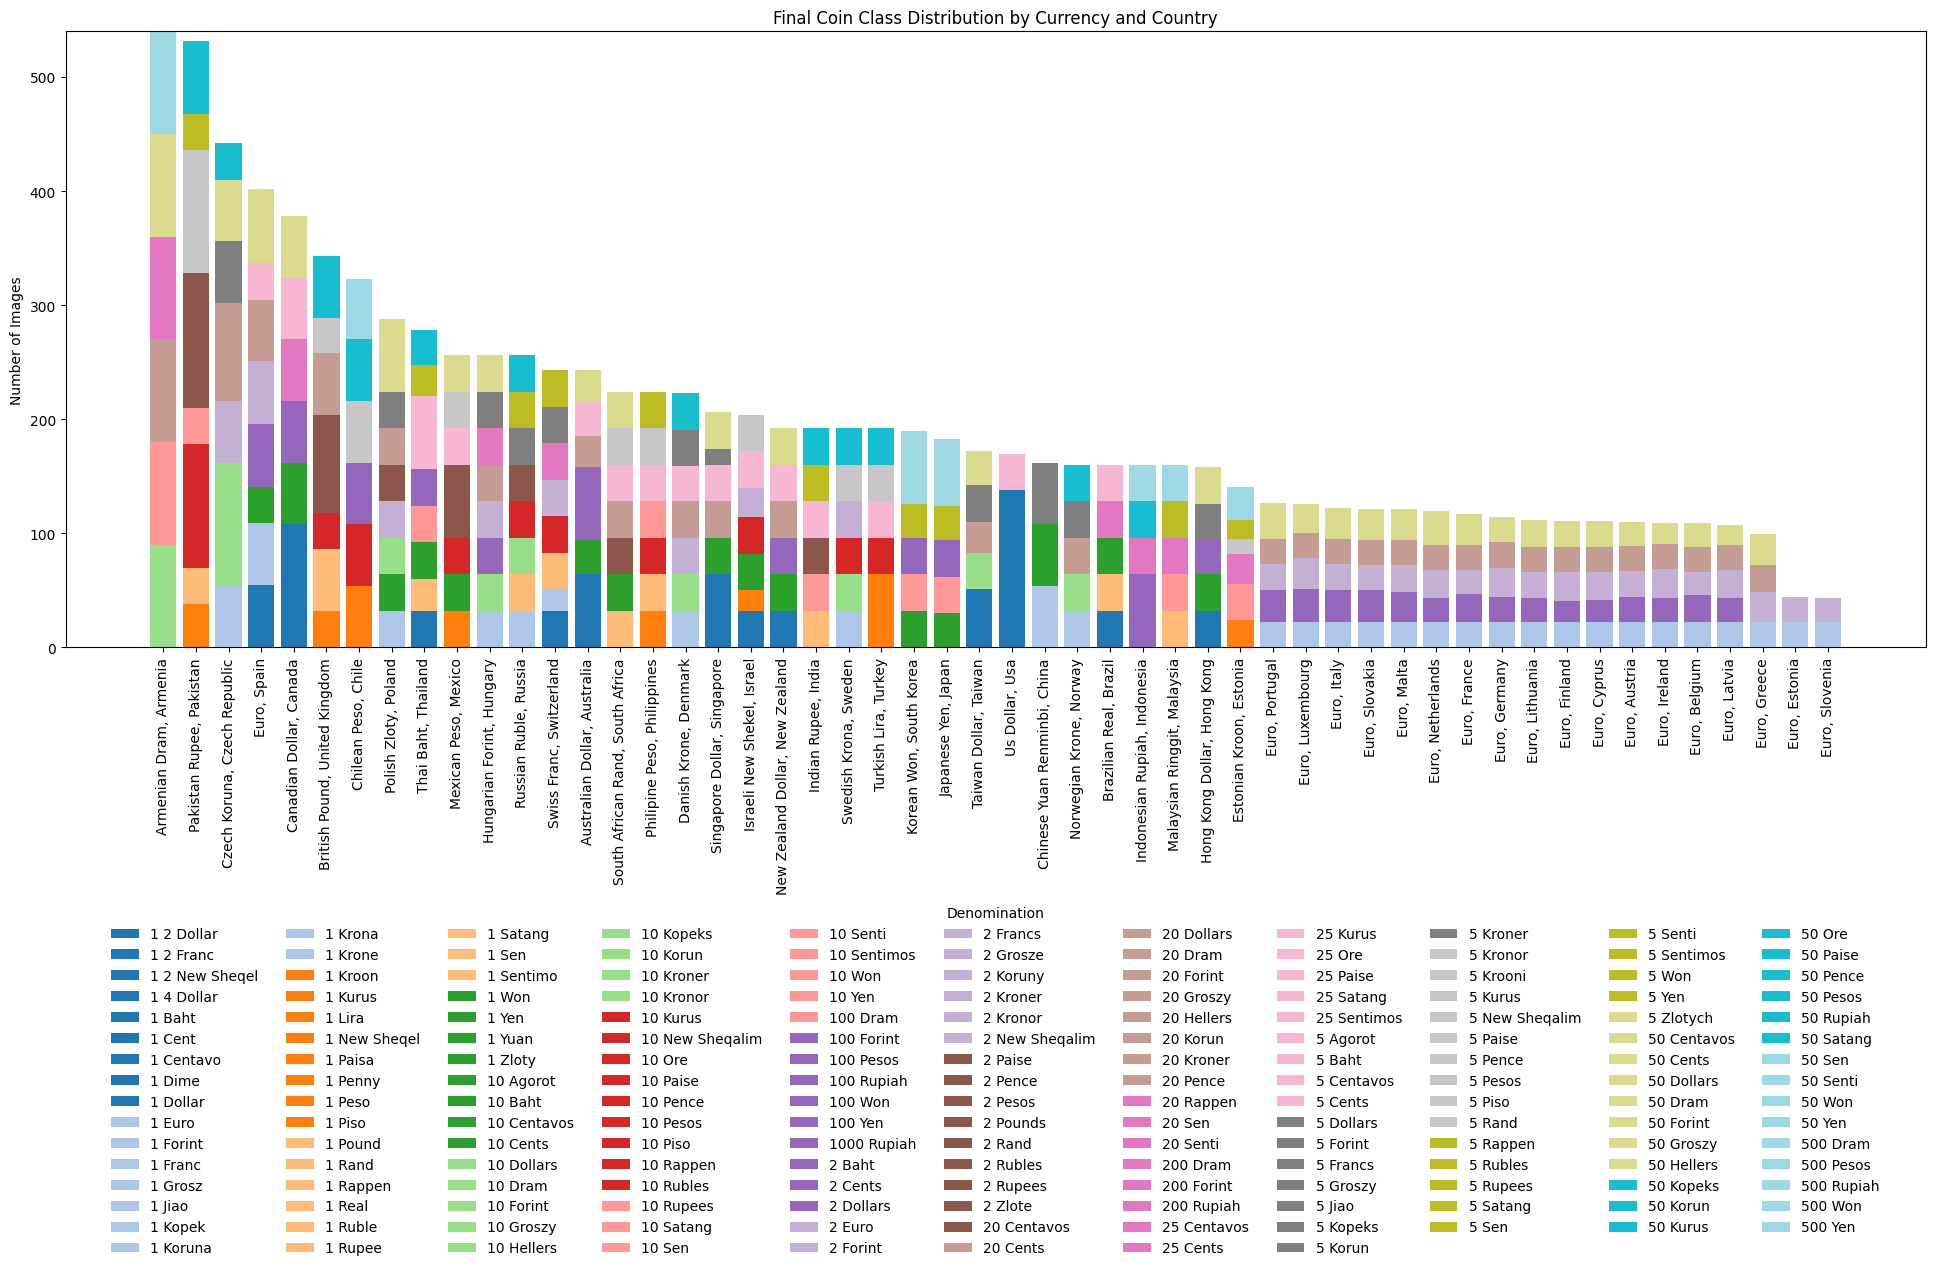

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

_df = train_df.copy()
_df['currency_n_country'] = _df['currency'].str.strip() + ', ' + _df['country'].str.strip()
grouped = _df.groupby(['currency_n_country', 'denomination']).size().unstack(fill_value=0)
grouped = grouped.loc[grouped.sum(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(24, 8))
x = np.arange(len(grouped))
bottom = np.zeros(len(grouped))

for i, denom in enumerate(grouped.columns):
    values = grouped[denom].values
    colors = plt.cm.tab20(np.linspace(0, 1, len(grouped.columns)))
    ax.bar(x, values, bottom=bottom, width=0.8, color=colors[i])
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(grouped.index, rotation=90)
ax.set_title("Final Coin Class Distribution by Currency and Country")
ax.set_ylabel("Number of Images")
ax.legend(grouped.columns, title='Denomination', loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=11, frameon=False)
plt.show()

To validate our replacements, we print a few corrected examples and confirm the standardization has been applied successfully:

In [14]:
train_df[train_df["country"] == "Spain"].sort_values(by=['denomination']).head(5)

,Id,Class,denomination,currency,country
2274,2540,"1 euro Cent,Euro,spain",1 Cent,Euro,Spain
2304,2570,"1 euro Cent,Euro,spain",1 Cent,Euro,Spain
2305,2571,"1 euro Cent,Euro,spain",1 Cent,Euro,Spain
8196,9201,"1 Cent,Euro,spain",1 Cent,Euro,Spain
8195,9200,"1 Cent,Euro,spain",1 Cent,Euro,Spain


We find that the dataset is highly imbalanced: e.g., over 500 images of Armenian Drams compared to fewer than 100 for Estonian or Slovenian Euro coins. We will address this imbalance in the model training phase.

Before proceeding, we check for null values in the dataset to ensure we are working with clean data:

In [15]:
print("Missing values in training labels:", train_df.isnull().sum().sum())

Missing values in training labels: 0


After cleaning the data, we reconstruct the target classes and encode them using a `LabelEncoder` to prepare for multi-class classification:

In [16]:
from sklearn.preprocessing import LabelEncoder

train_df['class'] = train_df['denomination'] + ',' + train_df['currency'] + ',' + train_df['country']

label_encoder = LabelEncoder()
train_df['class_id'] = label_encoder.fit_transform(train_df['class'])
train_df

,Id,Class,denomination,currency,country,class,class_id
0,1,"1 Cent,Australian dollar,australia",1 Cent,Australian Dollar,Australia,"1 Cent,Australian Dollar,Australia",6
1,2,"1 Cent,Australian dollar,australia",1 Cent,Australian Dollar,Australia,"1 Cent,Australian Dollar,Australia",6
2,3,"1 Cent,Australian dollar,australia",1 Cent,Australian Dollar,Australia,"1 Cent,Australian Dollar,Australia",6
3,4,"1 Cent,Australian dollar,australia",1 Cent,Australian Dollar,Australia,"1 Cent,Australian Dollar,Australia",6
4,5,"1 Cent,Australian dollar,australia",1 Cent,Australian Dollar,Australia,"1 Cent,Australian Dollar,Australia",6
...,...,...,...,...,...,...,...
10363,11648,"50 Cents,Euro,spain",50 Cents,Euro,Spain,"50 Cents,Euro,Spain",280
10364,11649,"50 Cents,Euro,spain",50 Cents,Euro,Spain,"50 Cents,Euro,Spain",280
10365,11650,"50 Cents,Euro,spain",50 Cents,Euro,Spain,"50 Cents,Euro,Spain",280
10366,11651,"50 Cents,Euro,spain",50 Cents,Euro,Spain,"50 Cents,Euro,Spain",280


We then load and preprocess the images. This includes resizing, normalizing, and handling faulty or unsupported image files:

In [17]:
from sklearn.model_selection import train_test_split

SAMPLE_SIZE = len(train_df)
sample_df = train_df.sample(SAMPLE_SIZE, random_state=7)

files = os.listdir(TRAIN_DIR)
file_map = {os.path.splitext(f)[0]: f for f in files}

def load_images(df, img_dir, img_size):
    images = []
    labels = []
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        filename = file_map.get(str(row['Id']))
        if filename:
            img_path = os.path.join(img_dir, filename)
            img = Image.open(img_path).convert("RGB").resize((img_size, img_size))
            images.append(np.array(img))
            labels.append(row['class_id'])
        else:
            print(f"Missing file for id = {row['Id']}")
            continue
    return np.array(images), np.array(labels)

IMG_SIZE = 64
X, y = load_images(sample_df, TRAIN_DIR, IMG_SIZE)

 40%|██████████████▉                      | 4180/10368 [00:11<00:20, 298.60it/s]

Missing file for id = 10211


 61%|██████████████████████▋              | 6374/10368 [00:17<00:13, 299.73it/s]

Missing file for id = 11353


100%|████████████████████████████████████| 10368/10368 [00:28<00:00, 362.07it/s]

Missing file for id = 11270


In [18]:
X = X / 255.0
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

During preprocessing, we encountered some issues: 
- a few coin images were inaccessible due to permission errors and were replaced with screenshots;
- some others had no valid file extension and were removed from the dataset.

## 3. Model Building

Once preprocessing is complete, we begin building our models. We selected the following architectures:
1. **Baseline CNN**:
    - A lightweight convolutional neural network built from scratch, featuring 3 `Conv2D` and 2 `MaxPooling2D` layers;
    - This model serves as a fast, simple benchmark for comparison.
2. **ResNet50**:
    - A 50-layer deep CNN architecture that includes residual connections;
    - Pretrained on ImageNet, this model is known for its depth and robustness.
3. **DenseNet121**:
    - A deep CNN architecture pretrained on ImageNet;
    - It features a densely connected architecture, where each layer receives input from all previous layers, enhancing gradient flow and feature reuse;
    - We expect this model will yield the highest performance.

Next, we define the following layers for our baseline model:
- **Conv2D layers** extract visual features like edges and textures. We progressively increase the number of filters (32 → 64 → 128) to learn increasingly complex features.
- **MaxPooling2D layers** downsample feature maps to reduce computational cost and help generalize the model.
- **Flatten** converts the 3D feature maps into a 1D vector so we can connect it to dense layers.
- **Dense layers** serve as fully connected decision layers.

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_baseline_cnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_df['class_id'].nunique(), activation='softmax')
    ])
    return model

baseline_model = build_baseline_cnn((IMG_SIZE, IMG_SIZE, 3))
baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We now define both the ResNet50 and DenseNet121 models. Each is followed by a global average pooling layer and two fully connected layers, including a dense layer with 256 neurons and a 50% dropout layer to prevent overfitting:

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import optimizers

def build_resnet50_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_df['class_id'].nunique(), activation='softmax')
    ])
    return model

resnet50_model = build_resnet50_model((IMG_SIZE, IMG_SIZE, 3))
resnet50_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
from tensorflow.keras.applications import DenseNet121

def build_densenet121_model(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_df['class_id'].nunique(), activation='softmax')
    ])
    return model

densenet121_model = build_densenet121_model((IMG_SIZE, IMG_SIZE, 3))
densenet121_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 5. Model Training

In the next step, we train all three models — Baseline CNN, ResNet50, and DenseNet121 — for 10 epochs using a batch size of 32. This allows us to identify trends early on without excessive training time:

In [23]:
baseline = baseline_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32)

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4233 - loss: 2.4458 - val_accuracy: 0.5248 - val_loss: 2.5461
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4470 - loss: 2.3107 - val_accuracy: 0.5364 - val_loss: 2.4833
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4701 - loss: 2.1479 - val_accuracy: 0.5480 - val_loss: 2.4105
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4997 - loss: 1.9827 - val_accuracy: 0.5630 - val_loss: 2.3959
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5229 - loss: 1.8843 - val_accuracy: 0.5620 - val_loss: 2.3390
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5541 - loss: 1.7580 - val_accuracy: 0.5692 - val_loss: 2.3562
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5497 - loss: 1.7109 - val_accuracy: 0.5808 - val_loss: 2.3593
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5779 - loss: 1.5894 - val_accu

In [24]:
resnet50 = resnet50_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32)

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 91s 319ms/step - accuracy: 0.0496 - loss: 5.7807 - val_accuracy: 0.0053 - val_loss: 25.8868
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 84s 323ms/step - accuracy: 0.2170 - loss: 4.3755 - val_accuracy: 0.0063 - val_loss: 7.8515
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 332ms/step - accuracy: 0.3613 - loss: 3.4489 - val_accuracy: 0.0598 - val_loss: 5.3180
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 85s 327ms/step - accuracy: 0.4716 - loss: 2.6755 - val_accuracy: 0.4636 - val_loss: 2.8242
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - accuracy: 0.5889 - loss: 2.0296 - val_accuracy: 0.5929 - val_loss: 2.0540
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - accuracy: 0.6611 - loss: 1.5746 - val_accuracy: 0.6488 - val_loss: 1.7761
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 330ms/step - accuracy: 0.7510 - loss: 1.1234 - val_accuracy: 0.6546 - val_loss: 1.6829
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 332ms/step - accuracy: 0.8082 - loss: 

In [26]:
densenet121 = densenet121_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32)

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 70s 270ms/step - accuracy: 0.6145 - loss: 1.8282 - val_accuracy: 0.6179 - val_loss: 1.8796
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 73s 283ms/step - accuracy: 0.6720 - loss: 1.5167 - val_accuracy: 0.6363 - val_loss: 1.7572
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 73s 279ms/step - accuracy: 0.7308 - loss: 1.2454 - val_accuracy: 0.6715 - val_loss: 1.5706
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 72s 277ms/step - accuracy: 0.7719 - loss: 1.0197 - val_accuracy: 0.6763 - val_loss: 1.5089
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 72s 278ms/step - accuracy: 0.8130 - loss: 0.8246 - val_accuracy: 0.6816 - val_loss: 1.4753
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 71s 275ms/step - accuracy: 0.8407 - loss: 0.7000 - val_accuracy: 0.6893 - val_loss: 1.3841
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 70s 269ms/step - accuracy: 0.8677 - loss: 0.5782 - val_accuracy: 0.7110 - val_loss: 1.3260
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 70s 269ms/step - accuracy: 0.8974 - loss: 0

Initial training shows that maximum validation accuracy is achieved early, particularly in deeper models, with signs of overfitting. This is likely due to class imbalance, so we delay evaluation and instead address this imbalance during training.

To mitigate class imbalance, we compute class weights based on the training distribution. These weights penalize misclassifications of underrepresented classes more heavily, encouraging fairer learning:

In [27]:
from sklearn.utils.class_weight import compute_class_weight

num_classes = train_df['class_id'].nunique()

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)

class_weight_dict = dict(enumerate(class_weights))

In [28]:
baseline_weighted = baseline_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32,
    class_weight=class_weight_dict)

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6126 - loss: 1.5991 - val_accuracy: 0.5885 - val_loss: 2.3626
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6231 - loss: 1.5032 - val_accuracy: 0.6006 - val_loss: 2.3975
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6371 - loss: 1.4438 - val_accuracy: 0.5962 - val_loss: 2.4442
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6452 - loss: 1.3775 - val_accuracy: 0.5953 - val_loss: 2.4615
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6504 - loss: 1.3738 - val_accuracy: 0.5996 - val_loss: 2.3981
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6638 - loss: 1.2760 - val_accuracy: 0.6059 - val_loss: 2.5050
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6707 - loss: 1.2624 - val_accuracy: 0.5996 - val_loss: 2.5138
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6652 - loss: 1.2436 - val_accu

In [29]:
resnet50_weighted = resnet50_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32,
    class_weight=class_weight_dict)

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 82s 300ms/step - accuracy: 0.9010 - loss: 0.4713 - val_accuracy: 0.6903 - val_loss: 1.5251
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 79s 305ms/step - accuracy: 0.9090 - loss: 0.4317 - val_accuracy: 0.7014 - val_loss: 1.5519
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - accuracy: 0.9158 - loss: 0.3580 - val_accuracy: 0.6884 - val_loss: 1.5396
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 80s 306ms/step - accuracy: 0.9456 - loss: 0.2456 - val_accuracy: 0.7106 - val_loss: 1.4958
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 83s 320ms/step - accuracy: 0.9445 - loss: 0.2356 - val_accuracy: 0.7154 - val_loss: 1.5389
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 79s 304ms/step - accuracy: 0.9481 - loss: 0.2124 - val_accuracy: 0.7159 - val_loss: 1.5331
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 78s 302ms/step - accuracy: 0.9576 - loss: 0.1848 - val_accuracy: 0.7255 - val_loss: 1.5331
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 78s 301ms/step - accuracy: 0.9568 - loss: 0

In [30]:
densenet121_weighted = densenet121_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32,
    class_weight=class_weight_dict)

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 83s 292ms/step - accuracy: 0.9299 - loss: 0.3419 - val_accuracy: 0.7188 - val_loss: 1.3347
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 267ms/step - accuracy: 0.9228 - loss: 0.3794 - val_accuracy: 0.7217 - val_loss: 1.2901
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 72s 276ms/step - accuracy: 0.9205 - loss: 0.3581 - val_accuracy: 0.7356 - val_loss: 1.2557
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 72s 277ms/step - accuracy: 0.9373 - loss: 0.2929 - val_accuracy: 0.7270 - val_loss: 1.3074
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 70s 271ms/step - accuracy: 0.9548 - loss: 0.2168 - val_accuracy: 0.7337 - val_loss: 1.2884
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 267ms/step - accuracy: 0.9602 - loss: 0.1918 - val_accuracy: 0.7390 - val_loss: 1.2986
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 71s 271ms/step - accuracy: 0.9661 - loss: 0.1633 - val_accuracy: 0.7337 - val_loss: 1.3267
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 72s 276ms/step - accuracy: 0.9510 - loss: 0

Training with class weights shows a clear improvement. The models converge faster and reach higher validation accuracy, especially on rare classes. We analyze this further in the next section.

## 6. Model Evaluation

We now evaluate the weighted models based on their performance metrics, especially focusing on accuracy and ROC-AUC:

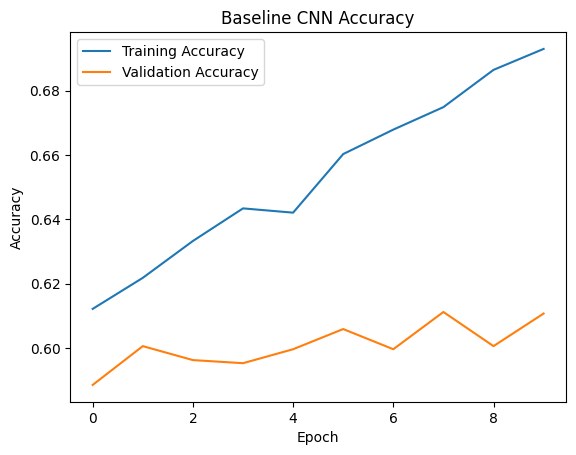

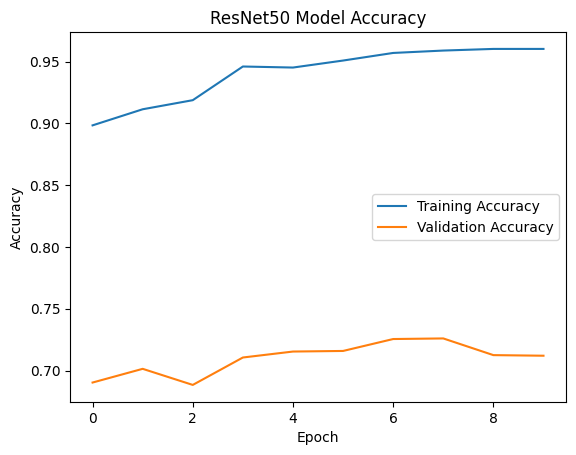

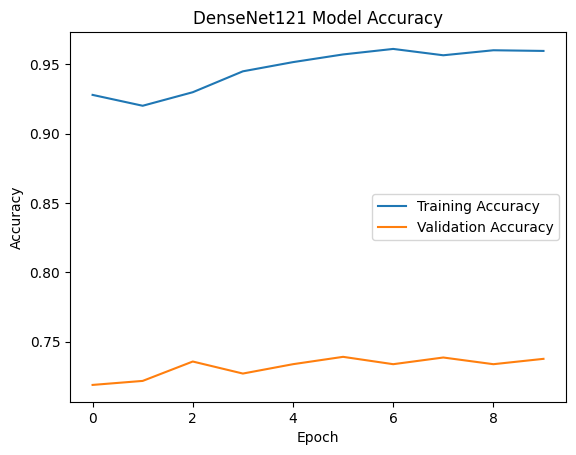

In [38]:
def plot_accuracy(model, title):
    plt.plot(model.history['accuracy'], label='Training Accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(baseline_weighted, 'Baseline CNN Accuracy')
plot_accuracy(resnet50_weighted, 'ResNet50 Model Accuracy')
plot_accuracy(densenet121_weighted, 'DenseNet121 Model Accuracy')

- Baseline CNN:
    - Starts off well and improves during training;
    - But the validation accuracy doesn’t get much better after a few epochs and even dips slightly;
    - This tells us the model is learning the training data but struggling to generalize — a mild case of overfitting.
- ResNet50:
    - Looks great on the training side — accuracy shoots up fast;
    - But the validation accuracy stays stuck around 71–72%, which isn’t ideal;
    - It’s clearly overfitting and not learning to generalize well. Needs some tuning before it can perform properly.
- DenseNet121:
    - The best overall performance.
    - Training goes smoothly and validation accuracy climbs up nicely to about 74%;
    - The gap between training and validation is smaller, which is a good sign — it generalizes better than the other two!

In [37]:
from sklearn.metrics import roc_auc_score

y_pred_baseline = baseline_model.predict(X_val)
y_pred_resnet50 = resnet50_model.predict(X_val)
y_pred_densenet121 = densenet121_model.predict(X_val)

auc_baseline = roc_auc_score(y_val, y_pred_baseline, multi_class='ovr')
auc_resnet50 = roc_auc_score(y_val, y_pred_resnet50, multi_class='ovr')
auc_densenet121 = roc_auc_score(y_val, y_pred_densenet121, multi_class='ovr')

print(f"Baseline CNN ROC-AUC: {auc_baseline}")
print(f"ResNet50 Model ROC-AUC: {auc_resnet50}")
print(f"DenseNet121 Model ROC-AUC: {auc_densenet121}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step
Baseline CNN ROC-AUC: 0.9661051888791279
ResNet50 Model ROC-AUC: 0.9783401350825686
DenseNet121 Model ROC-AUC: 0.9876807948544838


Considering ROC-AUC results on the validation set, we conclude that DenseNet121 captures true class distributions better than the others. Thus, we take DenseNet121 as a baseline for the hyperparameter tuning trying to achieve even better accuracy.

## 7. Hyperparameter Tuning for DenseNet121

We tune the following hyperparameters using Keras Tuner:
- Dense units: 64–512;
- Dropout rate: 0.3–0.7;
- Learning rate: 1e-4, 5e-4, 1e-3.

In [40]:
from keras_tuner import RandomSearch
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_densenet121_model_tuned(hp):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(train_df['class_id'].nunique(), activation='softmax')])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 5e-4, 1e-3])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_densenet121_model_tuned,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='densenet_tuning',
    project_name='coin_classification')

tuner.search(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    batch_size=32,
    class_weight=class_weight_dict)

Trial 10 Complete [00h 05m 51s]
val_accuracy: 0.5745296478271484

Best val_accuracy So Far: 0.586107075214386
Total elapsed time: 00h 49m 27s


In [41]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
print(f"Best hyperparameters: {best_hyperparams.values}")

Best hyperparameters: {'dense_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.0005}


/Users/yaroslavilichenko/miniconda3/envs/tensorflow_env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 734 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
densenet121_best = best_model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32)

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 80s 251ms/step - accuracy: 0.7021 - loss: 1.1809 - val_accuracy: 0.6281 - val_loss: 1.6991
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 66s 254ms/step - accuracy: 0.7628 - loss: 0.8496 - val_accuracy: 0.6189 - val_loss: 1.6989
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 67s 259ms/step - accuracy: 0.7897 - loss: 0.7433 - val_accuracy: 0.6860 - val_loss: 1.5230
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 265ms/step - accuracy: 0.8292 - loss: 0.5920 - val_accuracy: 0.6990 - val_loss: 1.4548
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 67s 258ms/step - accuracy: 0.8487 - loss: 0.5220 - val_accuracy: 0.7077 - val_loss: 1.3343
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 68s 260ms/step - accuracy: 0.8575 - loss: 0.4816 - val_accuracy: 0.6932 - val_loss: 1.5156
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 66s 255ms/step - accuracy: 0.8417 - loss: 0.5522 - val_accuracy: 0.7299 - val_loss: 1.3125
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 68s 263ms/step - accuracy: 0.8913 - loss: 0

In [44]:
y_pred_densenet121_best = best_model.predict(X_val)
auc_densenet121_best = roc_auc_score(y_val, y_pred_densenet121_best, multi_class='ovr')
print(f"DenseNet121 Best Model ROC-AUC: {auc_densenet121_best}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step
DenseNet121 Best Model ROC-AUC: 0.9896161007629166


Thus, we did not improve the final ROC-AUC value on the validation set and the hyperparameter tuning cannot be considered successful. This can be also observed on the following plot:

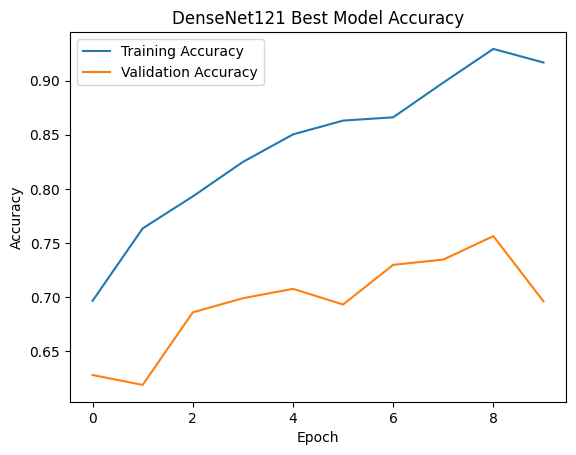

In [45]:
plot_accuracy(densenet121_best, 'DenseNet121 Best Model Accuracy')

The validation accuracy fluctuated and peaked slightly below the untuned version, and the validation loss remained high, suggesting potential overfitting or suboptimal parameter combinations.

## 8. Conclusion

In this study, we trained and evaluated three CNN-based models: a custom Baseline CNN, ResNet50, and DenseNet121. Among them, DenseNet121 demonstrated the most balanced and accurate performance. While ResNet50 and DenseNet121 showed high predictive capabilities, especially after class weighting, our analysis suggests room for further improvements:
- reducing dense layer size to combat overfitting,
- testing alternative image resolutions for better compatibility with deeper models,
- experimenting with data augmentation to increase diversity in underrepresented classes.

Our objective of establishing a robust baseline and leveraging transfer learning models has been successfully met.

## 9. References

- Geena Kim. DTSA 5511 Introduction to Deep Learning
- Geeksforgeeks. Image Classification using ResNet: https://www.geeksforgeeks.org/image-classification-using-resnet/
- Geeksforgeeks. DenseNet Explained: https://www.geeksforgeeks.org/densenet-explained/
- Vinicius Queiroz / Medium. Using Keras Tuner to Find the Best Hyperparameters for Your Neural Network Model: https://medium.com/@viniciusqroz/using-keras-tuner-to-find-the-best-parameters-for-your-neural-network-model-2dc02e0a1203